In [ ]:
!git clone https://github.com/sczhou/CodeFormer code_former

In [5]:
import numpy as np
import cv2
import torch
from torchvision.transforms.functional import normalize
import matplotlib.pyplot as plt

from code_former.basicsr.utils.registry import ARCH_REGISTRY
from code_former.basicsr.utils import img2tensor, tensor2img

In [2]:
checkpoint = torch.load('../code_former/weights/CodeFormer/codeformer.pth')['params_ema']
net = ARCH_REGISTRY.get('CodeFormer')(dim_embd=512,
                                      codebook_size=1024,
                                      n_head=8,
                                      n_layers=9,
                                      connect_list=['32', '64', '128', '256'])
net = net.to('cpu')
net.load_state_dict(checkpoint)
net.eval()

CodeFormer(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1-2): 2 x ResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Downsample(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      )
      (4): ResBlock(
        (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_out): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (5): ResBlock(
        (norm1): GroupNorm(32, 128, eps

In [4]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(net, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)

Flops estimation was not finished successfully because ofthe following exception:
<class 'RuntimeError'> : The size of tensor a (4) must match the size of tensor b (256) at non-singleton dimension 0


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/ptflops/pytorch_engine.py", line 62, in get_flops_pytorch
    _ = flops_model(batch)
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py", line 1568, in _call_impl
    result = forward_call(*args, **kwargs)
  File "/Workspace/code_former/basicsr/archs/codeformer_arch.py", line 241, in forward
    query_emb = layer(query_emb, query_pos=pos_emb)
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Workspace/code_former/basicsr/archs/codeformer_arch.py", line 125, in forward
    q = k = sel

TypeError: unsupported operand type(s) for //: 'NoneType' and 'int'

In [6]:
def load_code_former(weights: str):
    checkpoint = torch.load(weights)['params_ema']
    net = ARCH_REGISTRY.get('CodeFormer')(dim_embd=512,
                                          codebook_size=1024,
                                          n_head=8,
                                          n_layers=9,
                                          connect_list=['32', '64', '128', '256'])
    net = net.to('cpu')
    net.load_state_dict(checkpoint)
    net.eval()

    return net

def preprocess_code_former_input(image: np.ndarray):
    prep_img = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
    prep_img = img2tensor(prep_img / 255., bgr2rgb=True, float32=True)

    prep_img = normalize(prep_img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    prep_img = prep_img.unsqueeze(0).to('cpu')
    return prep_img

def restore_face(image: np.ndarray,
                 weights: str = '../code_former/weights/CodeFormer/codeformer.pth',
                 fidelity_weight: float = 1.0):

    net = load_code_former(weights)

    prep_img = preprocess_code_former_input(image)

    with torch.no_grad():
        output = net(prep_img, w=fidelity_weight, adain=True)[0]
        restored_face = tensor2img(output, rgb2bgr=True, min_max=(-1, 1))

    restored_face = cv2.cvtColor(restored_face, cv2.COLOR_RGB2BGR)
    return restored_face

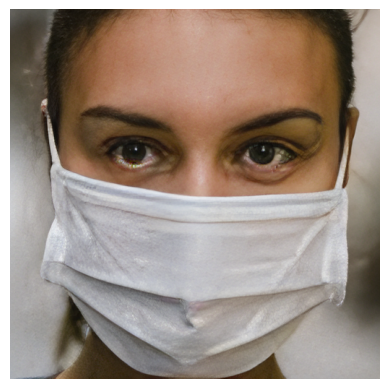

In [8]:
image = cv2.imread('700.png')
restored_face = restore_face(image)

plt.imshow(restored_face)
plt.axis('off')
plt.show()